# Randomized Optimization (Three Optimization Problems)

Author: Richard Huang

Fall 2020

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose_hiive as mlrose
import numpy as np

import time
import itertools
import matplotlib.pyplot as plt

In [2]:
RANDOM_STATE = 17
GRAPHS_PATH = "graphs/"

NB_STEP2 = 5

In [3]:
MAX_ATTEMPTS = [15, 15, 15, 15]
MAX_ITERS = [np.inf for _ in range(4)]
DICT_NAMES = {'RHC' :"Random Hill Climbing", 
              'SA': "Simulated Annealing", 
              'GA': "Genetic Algorithms", 
              'MI': "MIMIC"}

## Three Optimization problems functions

In [4]:
def minimization_problem(best_fitness, curves):
    offset = np.max(curves)
    new_curves = [-x+offset for x in curves]
    new_fitness = -best_fitness+offset

    return (new_fitness, new_curves)

In [5]:
def run_random_opti_algo(problem_fit, max_attempts=[10, 10, 10, 10], max_iters=[400, 400, 400, 400],
                         init_temp=1.0, exp_const=0.005, min_temp=0.001, # SA parameters
                         pop_size_ga=200, mutation_prob_ga=0.1, # GA parameters
                         pop_size_mi=200, keep_pct_mi=0.2, # MIMIC parameters
                         minimization=False, run_algos=[True, True, True, True],
                         random_state=RANDOM_STATE):
    """
    Returns dictionary history of best state, best fitness, history fitness and duration for an algorithm.
    Keys: RHB, SA, GA, MI.
    """
    np.random.seed(random_state)

    history = {}
    timer = time.time()

    # RHC
    if run_algos[0]:
        best_state_rhb, best_fitness_rhb, curves_rhb = mlrose.random_hill_climb(problem_fit, max_attempts=max_attempts[0], max_iters=max_iters[0], 
                                                                                curve=True, random_state=random_state)
        current_time = time.time()

        if minimization: best_fitness_rhb, curves_rhb = minimization_problem(best_fitness_rhb, curves_rhb)
        history['RHC'] = [best_state_rhb, best_fitness_rhb, curves_rhb, current_time-timer]
        timer = current_time

    # SA
    if run_algos[1]:
        best_state_sa, best_fitness_sa, curves_sa = mlrose.simulated_annealing(problem_fit, 
                                                                               schedule=mlrose.ExpDecay(init_temp=init_temp, exp_const=exp_const, min_temp=min_temp),
                                                                               max_attempts=max_attempts[1], max_iters=max_iters[1], 
                                                                               curve=True, random_state=random_state)
        current_time = time.time()

        if minimization: best_fitness_sa, curves_sa = minimization_problem(best_fitness_sa, curves_sa)
        history['SA'] = [best_state_sa, best_fitness_sa, curves_sa, current_time-timer]
        timer = current_time

    # GA
    if run_algos[2]:
        best_state_ga, best_fitness_ga, curves_ga = mlrose.genetic_alg(problem_fit, pop_size=pop_size_ga, mutation_prob=mutation_prob_ga, 
                                                                       max_iters=max_iters[2], max_attempts=max_attempts[2], 
                                                                       curve=True, random_state=random_state)
        current_time = time.time()

        if minimization: best_fitness_ga, curves_ga = minimization_problem(best_fitness_ga, curves_ga)
        history['GA'] = [best_state_ga, best_fitness_ga, curves_ga, current_time-timer]
        timer = current_time

    # MIMIC
    if run_algos[3]:
        best_state_mi, best_fitness_mi, curves_mi = mlrose.mimic(problem_fit, pop_size=pop_size_mi, keep_pct=keep_pct_mi, 
                                                                 max_attempts=max_attempts[3], max_iters=max_iters[3], 
                                                                 curve=True, random_state=random_state)
        current_time = time.time()

        if minimization: best_fitness_mi, curves_mi = minimization_problem(best_fitness_mi, curves_mi)
        history['MI'] = [best_state_mi, best_fitness_mi, curves_mi, current_time-timer]
        timer = current_time
    
    return history

In [38]:
def plot_fitness_duration(size_list, list_history, problem_name="", graphs_path=GRAPHS_PATH, do_save=True):
    """
    Plotting function after running the algorithms.
    """
    list_keys = list_history[0].keys()
    hist_fitness = {key: [] for key in list_keys}
    hist_duration = {key: [] for key in list_keys}
    for key in list_keys:
        for history in list_history:
            new_fitness = history[key][1]
            new_duration = history[key][3]

            hist_fitness[key].append(new_fitness)
            hist_duration[key].append(new_duration)

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title(f'Fitness score per problem size')
    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax[0].plot(size_list, hist_fitness[key], label=label_name)
    ax[0].set_xlabel('N (Problem size)')
    ax[0].set_ylabel('Fitness')
    ax[0].legend()

    ax[1].set_title(f'Running time (s)')
    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax[1].plot(size_list, hist_duration[key], label=label_name)
    ax[1].set_xlabel('N (Problem size)')
    ax[1].set_ylabel('Running time')
    ax[1].legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name}_fitness_duration.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()


def plot_fitness_iterations2(history, problem_name="", graphs_path=GRAPHS_PATH, do_save=True):
    list_keys = history.keys()
    hist_fitness = {key: [] for key in list_keys}
    hist_iterations = {key: [] for key in list_keys}
    
    for key in list_keys:
        list_fitness = history[key][2]
        hist_fitness[key] = list_fitness
        hist_iterations[key] = np.linspace(0, len(list_fitness), len(list_fitness))
    
    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    ax.set_title(f'Fitness score per iteration')
    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax.plot(hist_iterations[key], hist_fitness[key], label=label_name)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name}_fitness_iteration.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()
    
def plot_fitness_iterations(list_history, problem_name="", graphs_path=GRAPHS_PATH, do_save=True):
    list_keys = list_history[0].keys()
    hist_fitness = {key: [] for key in list_keys}
    hist_fitness_std = {key: [] for key in list_keys}
    hist_iterations = {key: [] for key in list_keys}

    for key in list_keys:
        list_history_fitness = []
        max_iterations = 0
        for idx in range(len(list_history)):
            new_array = np.array(list_history[idx][key][2])
            list_history_fitness.append(new_array)
            if max_iterations < len(new_array):
                max_iterations = len(new_array)

        for idx in range(len(list_history_fitness)):
            current_array = list_history_fitness[idx]
            max_fitness = np.max(current_array)
            list_history_fitness[idx] = np.concatenate((current_array, max_fitness*np.ones(max_iterations-len(current_array))))
        fitness_mean = np.mean(list_history_fitness, axis=0)
        fitness_std = np.std(list_history_fitness, axis=0)
        hist_fitness[key] = fitness_mean
        hist_fitness_std[key] = fitness_std
        hist_iterations[key] = np.linspace(0, len(fitness_mean), len(fitness_mean))

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    ax.set_title(f'Fitness score per iteration')
    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax.plot(hist_iterations[key], hist_fitness[key], label=label_name, alpha=0.9)
        ax.fill_between(hist_iterations[key], hist_fitness[key]-2*hist_fitness_std[key], hist_fitness[key]+2*hist_fitness_std[key], alpha=0.2)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name}_fitness_iteration.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()


def plot_iterations_size(size_list, list_history, problem_name="", graphs_path=GRAPHS_PATH, do_save=True):
    list_keys = list_history[0].keys()
    hist_iterations = {key: [] for key in list_keys}
    hist_duration = {key: [] for key in list_keys}
    for key in list_keys:
        for history in list_history:
            number_iterations = len(history[key][2])
            new_duration = history[key][3]

            hist_iterations[key].append(number_iterations)
            hist_duration[key].append(new_duration)

    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    ax.set_title(f'Iterations per problem size')

    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax.plot(size_list, hist_iterations[key], label=label_name)
    ax.set_ylabel('Iterations')
    ax.set_xlabel('N (Problem size)')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name}_iteration_size.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()
    
def plot_time_iterations_size(size_list, list_history, problem_name="", graphs_path=GRAPHS_PATH, do_save=True):
    list_keys = list_history[0].keys()
    hist_iterations = {key: [] for key in list_keys}
    for key in list_keys:
        for history in list_history:
            number_iterations = len(history[key][2])
            new_duration = history[key][3]

            hist_iterations[key].append(new_duration/number_iterations)

    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    ax.set_title(f'Running time/Iteration per problem size')

    for key in list_keys:
        label_name = DICT_NAMES[key]
        ax.plot(size_list, hist_iterations[key], label=label_name)
    ax.set_ylabel('Running time/Iteration')
    ax.set_xlabel('N (Problem size)')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name}_time_iteration_size.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()

    for key in list_keys:
        print(f"Average running time/iteration for {key}: {np.mean(hist_iterations[key])} seconds/iteration")

In [8]:
parameters_dict = {'SA': [0.5, 0.05, 0.005, 0.0005], 
                   'GA': [[100, 200, 400], [0.01, 0.1, 0.4, 0.8]], 
                   'MI': [[100, 200, 400], [0.2, 0.4, 0.6, 0.8]]}

def gridsearch_sa(parameters_dict, create_problem, problem_params, minimization=False, 
                  problem_name="", do_save=True, graphs_path=GRAPHS_PATH):
    list_history = []

    for exp_const in parameters_dict['SA']:
        print(f"Computing SA for exp_const={exp_const}...")
        problem_fit = create_problem(**problem_params)
        history = run_random_opti_algo(problem_fit, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                       init_temp=1.0, exp_const=exp_const, min_temp=0.001, # SA parameters
                                       run_algos=[False, True, False, False], 
                                       minimization=minimization)
        list_history.append((exp_const, history))

    print("Plotting...")
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    
    ax.set_title(f'Gridsearch SA')

    for exp_const, history in list_history:
        curves = history['SA'][2]
        ax.plot(np.arange(len(curves)), curves, label=f'exp_const={exp_const}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name} Gridsearch SA.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()


def gridsearch_ga(parameters_dict, create_problem, problem_params, minimization=False, 
                  problem_name="", do_save=True, graphs_path=GRAPHS_PATH):
    list_history = []

    for pop_size_ga in parameters_dict['GA'][0]:
        for mutation_prob_ga in parameters_dict['GA'][1]:
            print(f"Computing GA for pop_size_ga={pop_size_ga} and mutation_prob_ga={mutation_prob_ga}...")
            problem_fit = create_problem(**problem_params)
            history = run_random_opti_algo(problem_fit, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                           pop_size_ga=pop_size_ga, mutation_prob_ga=mutation_prob_ga, 
                                           run_algos=[False, False, True, False], 
                                           minimization=minimization)
            list_history.append((pop_size_ga, mutation_prob_ga, history))

    print("Plotting...")
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    
    ax.set_title(f'Gridsearch GA')

    for pop_size_ga, mutation_prob_ga, history in list_history:
        curves = history['GA'][2]
        ax.plot(np.arange(len(curves)), curves, label=f'pop_size={pop_size_ga}|mut_prob={mutation_prob_ga}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name} Gridsearch GA.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()
    
def gridsearch_mi(parameters_dict, create_problem, problem_params, minimization=False, 
                  problem_name="", do_save=True, graphs_path=GRAPHS_PATH):
    list_history = []

    for pop_size_mi in parameters_dict['MI'][0]:
        for keep_pct_mi in parameters_dict['MI'][1]:
            print(f"Computing MI for pop_size_mi={pop_size_mi} and keep_pct_mi={keep_pct_mi}...")
            problem_fit = create_problem(**problem_params)
            history = run_random_opti_algo(problem_fit, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                           pop_size_mi=pop_size_mi, keep_pct_mi=keep_pct_mi, 
                                           run_algos=[False, False, False, True], 
                                           minimization=minimization)
            list_history.append((pop_size_mi, keep_pct_mi, history))

    print("Plotting...")
    fig, ax = plt.subplots(1, 1, figsize=(15,5))
    
    ax.set_title(f'Gridsearch MI')

    for pop_size_mi, keep_pct_mi, history in list_history:
        curves = history['MI'][2]
        ax.plot(np.arange(len(curves)), curves, label=f'pop_size={pop_size_mi}|keep_pct={keep_pct_mi}')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Fitness')
    ax.legend()

    if do_save:
        save_graph_path = f"{graphs_path}{problem_name} Gridsearch MI.png"
        plt.savefig(save_graph_path)
        print(f"Graphs saved at {save_graph_path}")

    plt.show()

# Travelling Saleperson

In [9]:
def create_tsp_problem(max_dist=10, max_cities=100, use_distance=False, random_state=RANDOM_STATE):

    if not use_distance:
        np.random.seed(random_state)
        x_coord = np.random.randint(1, max_dist+1, max_cities)
        y_coord = np.random.randint(1, max_dist+1, max_cities)
        coord_array = np.vstack((x_coord, y_coord))

        # Create list of city coordinates
        coords_list = list(set([(coord_array[0,i], coord_array[1,i]) for i in range(coord_array.shape[1])]))
        nb_cities = len(coords_list)

        # Initialize fitness function object using coords_list
        fitness_coords = mlrose.TravellingSales(coords=coords_list)

        # Define optimization problem object
        problem_fit = mlrose.TSPOpt(length=nb_cities, fitness_fn=fitness_coords, maximize=False)

    else:
        # Create list of distances between pairs of cities
        list_test = [x for x in list(itertools.product(range(max_cities), repeat=2))]
        dist_list = []  
        for coords in list_test:
            x, y = coords
            if x != y and (y, x) not in dist_list:
                dist_list.append((x, y, np.random.uniform(0.01, max_dist)))
        
        nb_cities = len(dist_list)
        print(dist_list)

        # Initialize fitness function object using dist_list
        fitness_dists = mlrose.TravellingSales(distances = dist_list)

        # Define optimization problem object
        problem_fit = mlrose.TSPOpt(length=nb_cities, fitness_fn=fitness_dists, maximize=False)

    return problem_fit

Computing SA for exp_const=0.5...
Computing SA for exp_const=0.05...
Computing SA for exp_const=0.005...
Computing SA for exp_const=0.0005...
Plotting...
Graphs saved at graphs/Travelling Saleperson Gridsearch SA.png


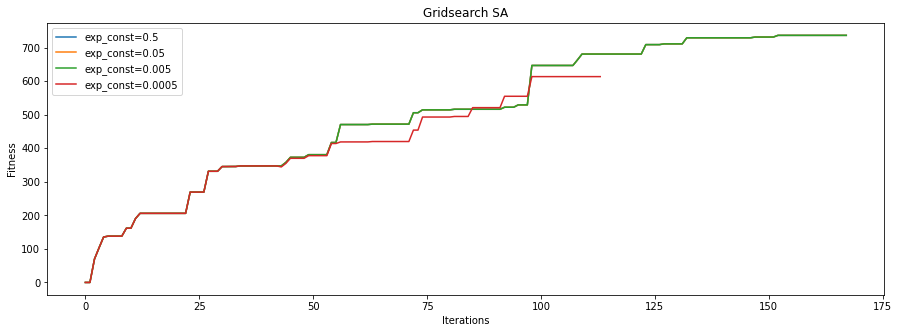

Wall time: 391 ms


In [10]:
%%time
problem_params = {'max_dist': 100, 'max_cities': 30}
gridsearch_sa(parameters_dict, create_tsp_problem, problem_params, minimization=True, problem_name="Travelling Saleperson")

Computing GA for pop_size_ga=100 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.8...
Plotting...
Graphs saved at graphs/Travelling Saleperson Gridsearch GA.png


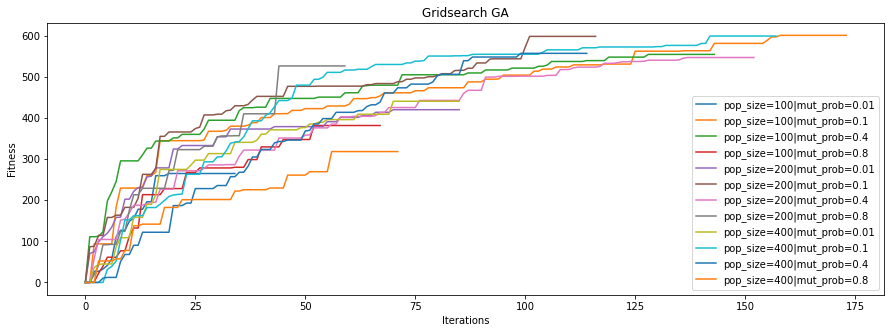

Wall time: 1min


In [11]:
%%time
gridsearch_ga(parameters_dict, create_tsp_problem, problem_params, minimization=True, problem_name="Travelling Saleperson")

Computing MI for pop_size_mi=100 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.8...
Plotting...
Graphs saved at graphs/Travelling Saleperson Gridsearch MI.png


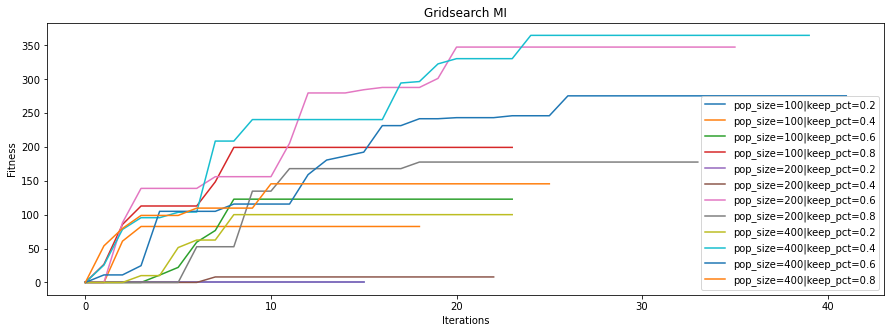

Wall time: 3min 58s


In [12]:
%%time
gridsearch_mi(parameters_dict, create_tsp_problem, problem_params, minimization=True, problem_name="Travelling Saleperson")

Graphs saved at graphs/Travelling Saleperson30_fitness_iteration.png


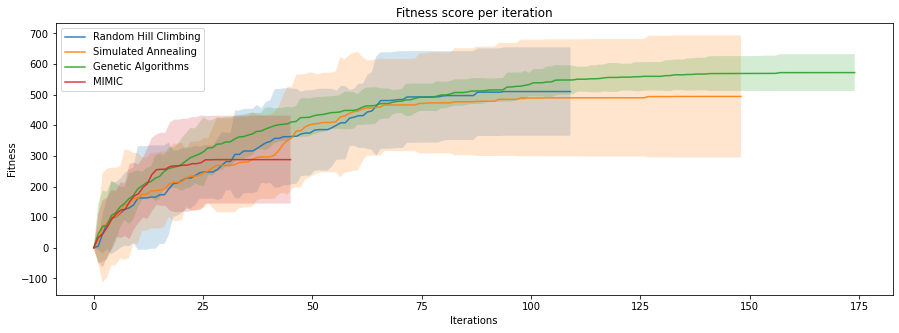

Wall time: 3min 24s


In [13]:
%%time
problem_fit_tsp = create_tsp_problem(max_dist=100, max_cities=30)

list_history_tsp_step2 = []
for idx in range(1, NB_STEP2+1):
    history = run_random_opti_algo(problem_fit_tsp, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1, exp_const=0.005, min_temp=0.001, 
                                   pop_size_ga=200, mutation_prob_ga=0.1, 
                                   pop_size_mi=400, keep_pct_mi=0.4, minimization=True, random_state=RANDOM_STATE+idx)
    list_history_tsp_step2.append(history)
plot_fitness_iterations(list_history_tsp_step2, problem_name="Travelling Saleperson30")

Graphs saved at graphs/Travelling Saleperson_fitness_iteration.png


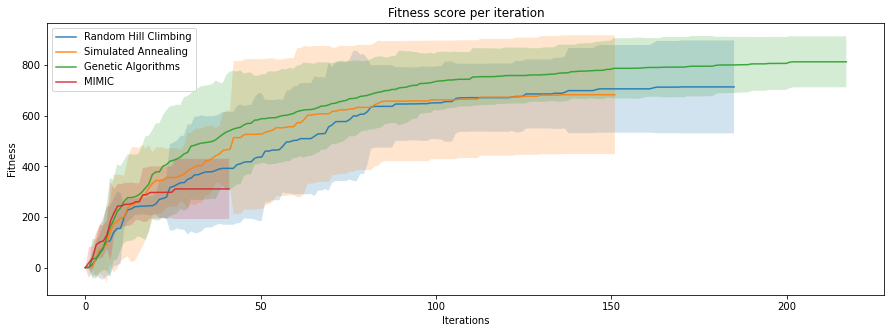

Wall time: 4min 36s


In [14]:
%%time
problem_fit_tsp = create_tsp_problem(max_dist=100, max_cities=40)

list_history_tsp_step2 = []
for idx in range(1, NB_STEP2+1):
    history = run_random_opti_algo(problem_fit_tsp, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1, exp_const=0.005, min_temp=0.001, 
                                   pop_size_ga=200, mutation_prob_ga=0.1, 
                                   pop_size_mi=400, keep_pct_mi=0.4, minimization=True, random_state=RANDOM_STATE+idx)
    list_history_tsp_step2.append(history)
plot_fitness_iterations(list_history_tsp_step2, problem_name="Travelling Saleperson")

Graphs saved at graphs/Travelling Saleperson_fitness_duration.png


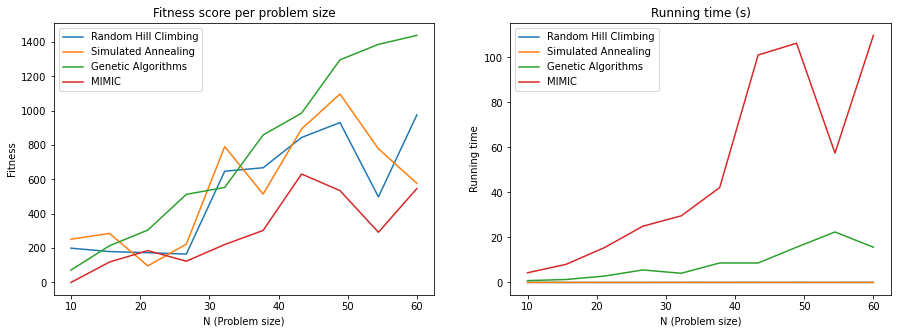

Wall time: 9min 45s


In [15]:
%%time

max_distance = 100
max_cities = 60
size_list_tsp = np.linspace(10, max_cities, 10)

list_history_tsp = []

for size in size_list_tsp:
    problem_fit_tsp = create_tsp_problem(max_dist=max_distance, max_cities=int(size))
    history = run_random_opti_algo(problem_fit_tsp, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1, exp_const=0.005, min_temp=0.001, 
                                   pop_size_ga=200, mutation_prob_ga=0.1, 
                                   pop_size_mi=400, keep_pct_mi=0.4,
                                   minimization=True)
    list_history_tsp.append(history)

plot_fitness_duration(size_list_tsp, list_history_tsp, problem_name="Travelling Saleperson")

Graphs saved at graphs/Travelling Saleperson_iteration_size.png


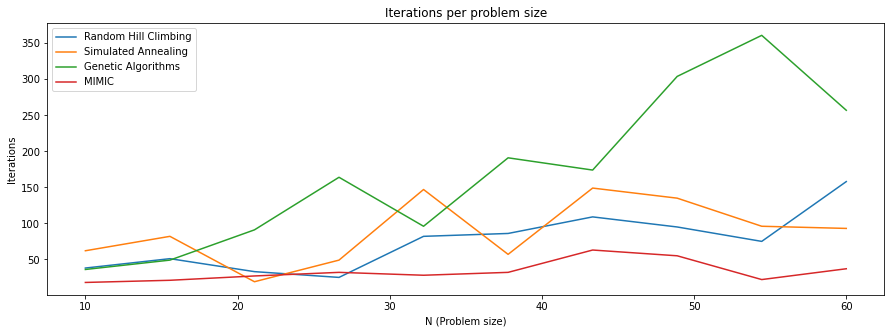

In [16]:
plot_iterations_size(size_list_tsp, list_history_tsp, problem_name="Travelling Saleperson")

Graphs saved at graphs/Travelling Saleperson_time_iteration_size.png


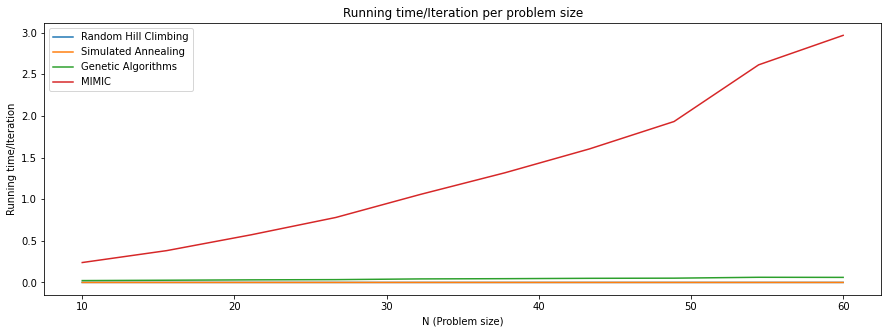

Average running time/iteration for RHC: 0.00014300316926460944 seconds/iteration
Average running time/iteration for SA: 0.00014102917019348578 seconds/iteration
Average running time/iteration for GA: 0.04263853291299794 seconds/iteration
Average running time/iteration for MI: 1.3467927406640536 seconds/iteration


In [39]:
plot_time_iterations_size(size_list_tsp, list_history_tsp, problem_name="Travelling Saleperson")

# Queens

In [18]:
def create_queens_problem(size=10):
    # Initialize fitness function
    fitness_queens = mlrose.Queens()

    # Define optimization problem object
    problem_fit = mlrose.DiscreteOpt(length=size, fitness_fn=fitness_queens, maximize=False, max_val=size) #size)

    return problem_fit

Computing SA for exp_const=0.5...
Computing SA for exp_const=0.05...
Computing SA for exp_const=0.005...
Computing SA for exp_const=0.0005...
Plotting...
Graphs saved at graphs/Queens Gridsearch SA.png


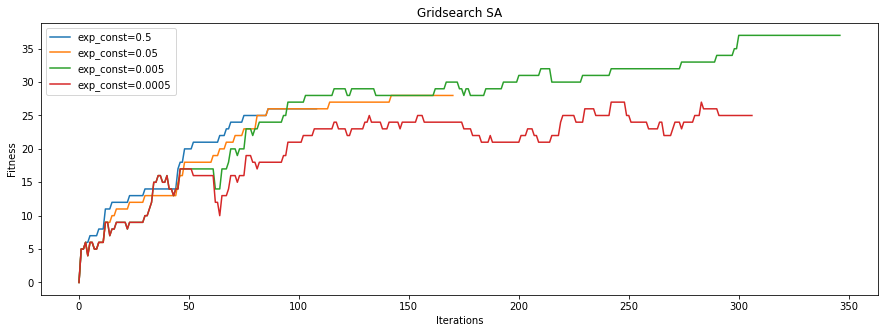

Wall time: 1.76 s


In [19]:
%%time
problem_params = {'size': 50}
gridsearch_sa(parameters_dict, create_queens_problem, problem_params, minimization=True, problem_name="Queens")

Computing GA for pop_size_ga=100 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.8...
Plotting...
Graphs saved at graphs/Queens Gridsearch GA.png


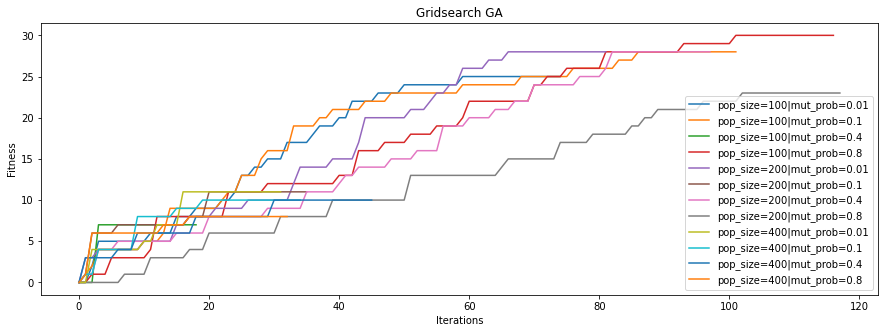

Wall time: 3min 4s


In [20]:
%%time
gridsearch_ga(parameters_dict, create_queens_problem, problem_params, minimization=True, problem_name="Queens")

Computing MI for pop_size_mi=100 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.8...
Plotting...
Graphs saved at graphs/Queens Gridsearch MI.png


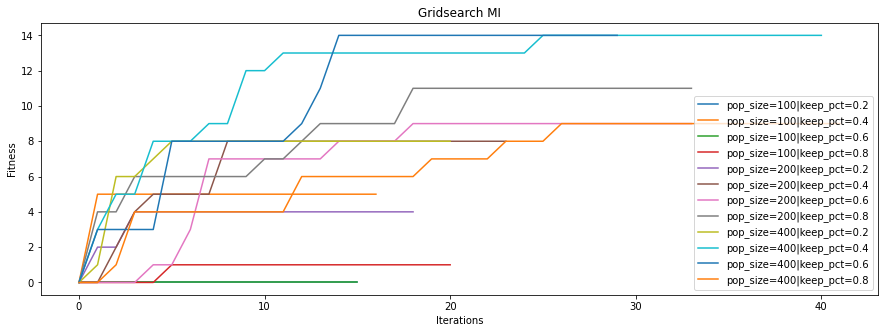

Wall time: 7min 30s


In [21]:
%%time
gridsearch_mi(parameters_dict, create_queens_problem, problem_params, minimization=True, problem_name="Queens")

Graphs saved at graphs/Queens_fitness_iteration.png


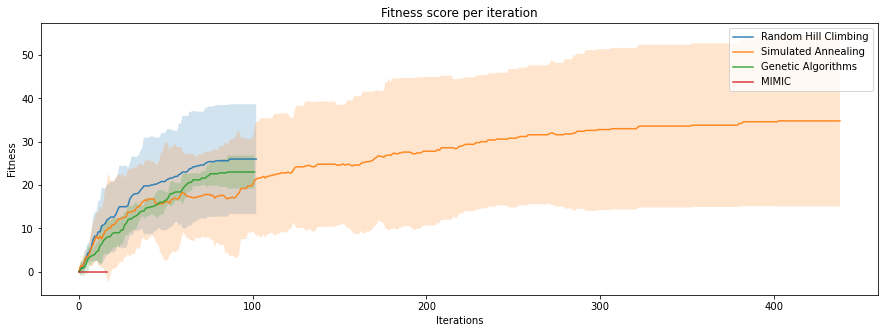

Wall time: 2min 34s


In [22]:
%%time
problem_fit_queens = create_queens_problem(size=50)

list_history = []
for idx in range(1, NB_STEP2+1):
    history = run_random_opti_algo(problem_fit_queens, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1, exp_const=0.005, min_temp=0.001, 
                                   pop_size_ga=100, mutation_prob_ga=0.8, 
                                   pop_size_mi=100, keep_pct_mi=0.2, minimization=True, random_state=RANDOM_STATE+idx)
    list_history.append(history)

plot_fitness_iterations(list_history, problem_name="Queens")

Graphs saved at graphs/Queens_fitness_duration.png


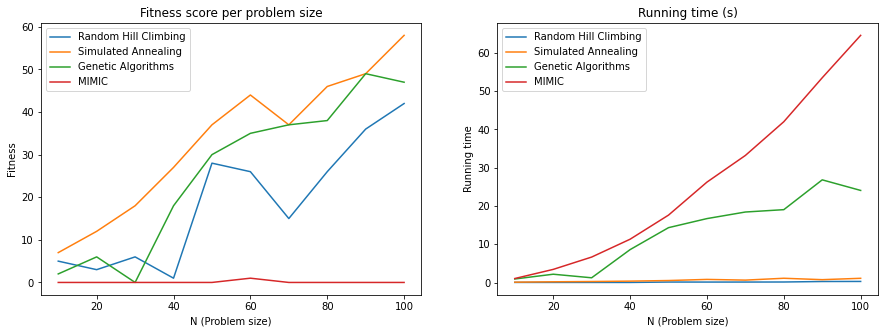

Wall time: 6min 39s


In [23]:
%%time

max_size = 100
size_list_queens = np.linspace(10, max_size, 10)

list_history_queens = []

for size in size_list_queens:
    problem_fit_queens = create_queens_problem(size=int(size))
    history = run_random_opti_algo(problem_fit_queens, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1, exp_const=0.005, min_temp=0.001, 
                                   pop_size_ga=100, mutation_prob_ga=0.8, 
                                   pop_size_mi=100, keep_pct_mi=0.2, minimization=True)
    list_history_queens.append(history)

plot_fitness_duration(size_list_queens, list_history_queens, problem_name="Queens")

Graphs saved at graphs/Queens_iteration_size.png


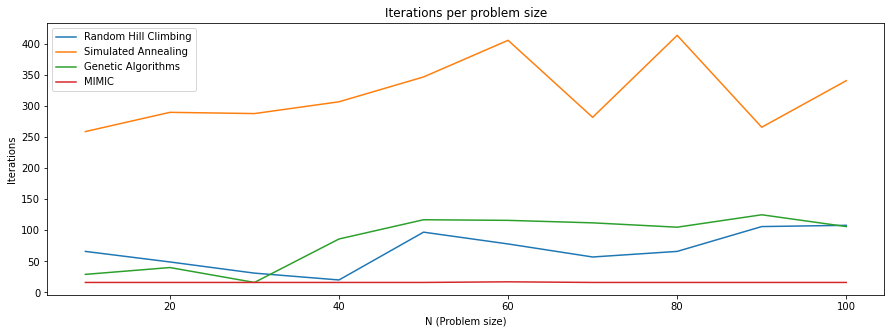

In [24]:
plot_iterations_size(size_list_queens, list_history_queens, problem_name="Queens")

Graphs saved at graphs/Queens_time_iteration_size.png


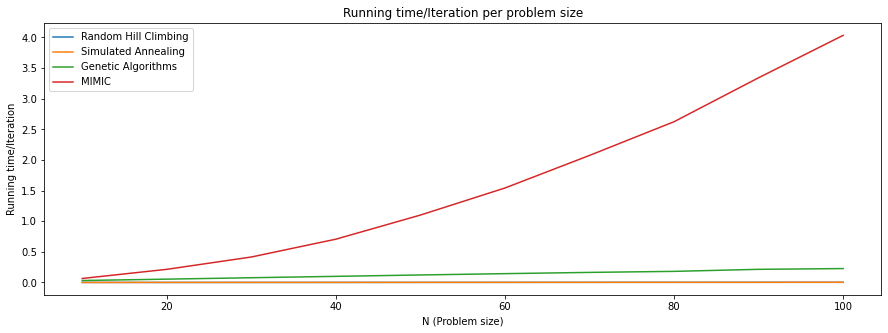

Average running time/iteration for RHC: 0.001510134670159854 seconds/iteration
Average running time/iteration for SA: 0.0017595366015256398 seconds/iteration
Average running time/iteration for GA: 0.13169593305048505 seconds/iteration
Average running time/iteration for MI: 1.6122429109671537 seconds/iteration


In [40]:
plot_time_iterations_size(size_list_queens, list_history_queens, problem_name="Queens")

# K-Flip-Flop

In [26]:
k = 3

def k_flip_flop(state):

   # Initialize counter
    fitness_cnt = 0

    # For all pairs of queens
    for i in range(1, len(state)-1):
        current_value = state[i]
        if state[i-1] == (current_value - 1) % k:
            fitness_cnt += 1
        if state[i+1] == (current_value + 1) % k:
            fitness_cnt += 1

    return fitness_cnt

def create_k_flip_flop_problem(size=10):
    # Initialize custom fitness function object
    fitness_cust = mlrose.CustomFitness(k_flip_flop)

    problem = mlrose.DiscreteOpt(length=size, fitness_fn=fitness_cust, maximize=True, max_val=k)
    
    return problem

Computing SA for exp_const=0.5...
Computing SA for exp_const=0.05...
Computing SA for exp_const=0.005...
Computing SA for exp_const=0.0005...
Plotting...
Graphs saved at graphs/K Flip Flop Gridsearch SA.png


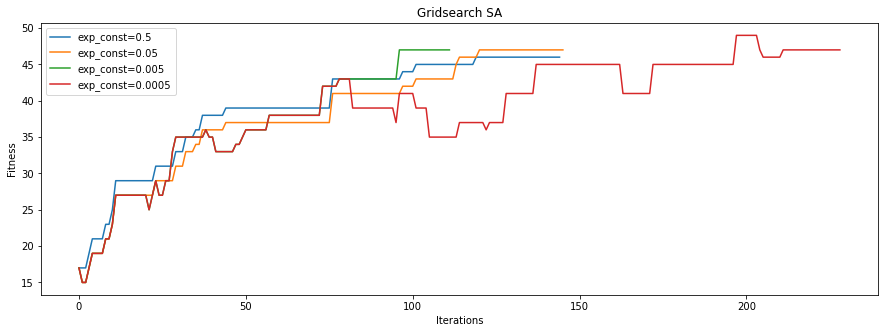

Wall time: 370 ms


In [27]:
%%time
problem_params = {'size': 30}
gridsearch_sa(parameters_dict, create_k_flip_flop_problem, problem_params, minimization=False, problem_name="K Flip Flop")

Computing GA for pop_size_ga=100 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=100 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=200 and mutation_prob_ga=0.8...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.01...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.1...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.4...
Computing GA for pop_size_ga=400 and mutation_prob_ga=0.8...
Plotting...
Graphs saved at graphs/K Flip Flop Gridsearch GA.png


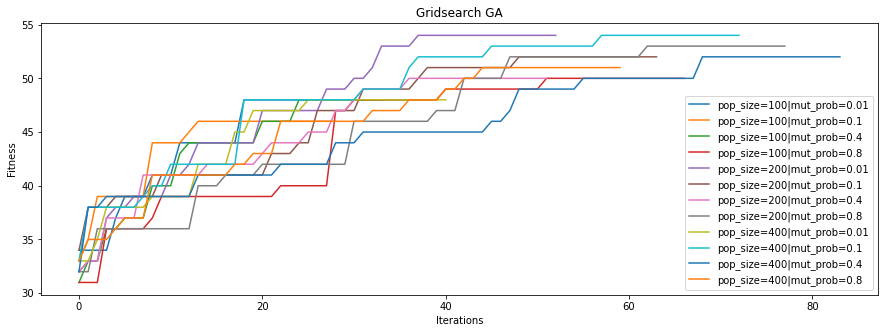

Wall time: 19.2 s


In [28]:
%%time
gridsearch_ga(parameters_dict, create_k_flip_flop_problem, problem_params, minimization=False, problem_name="K Flip Flop")

Computing MI for pop_size_mi=100 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=100 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=200 and keep_pct_mi=0.8...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.2...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.4...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.6...
Computing MI for pop_size_mi=400 and keep_pct_mi=0.8...
Plotting...
Graphs saved at graphs/K Flip Flop Gridsearch MI.png


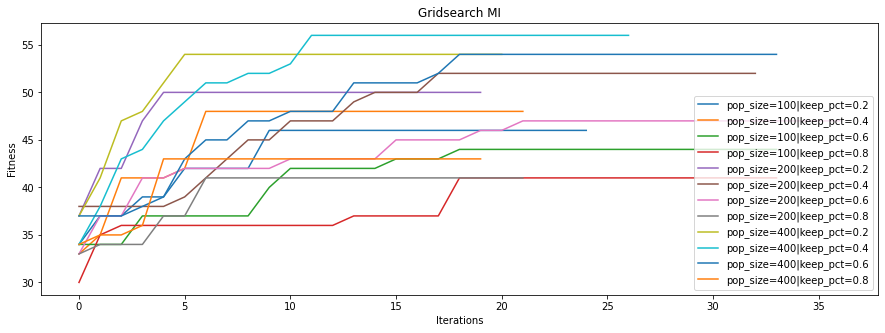

Wall time: 1min 47s


In [29]:
%%time
gridsearch_mi(parameters_dict, create_k_flip_flop_problem, problem_params, minimization=False, problem_name="K Flip Flop")

Graphs saved at graphs/K Flip Flop_fitness_iteration.png


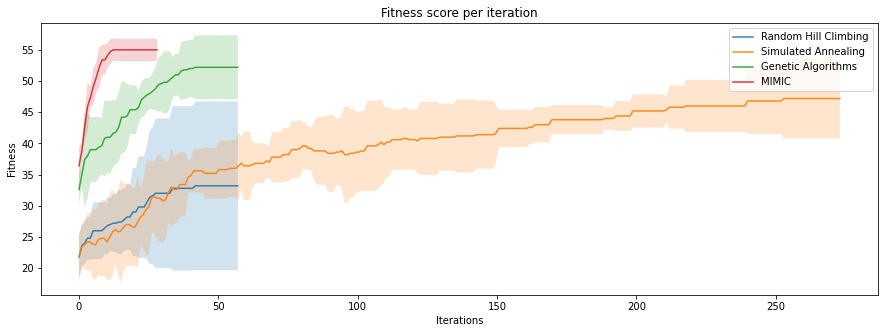

Wall time: 51.3 s


In [30]:
%%time
problem_fit = create_k_flip_flop_problem(size=30)

list_history_kflipflop_step2 = []
for idx in range(1, NB_STEP2+1):
    history = run_random_opti_algo(problem_fit, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1.0, exp_const=0.005, min_temp=0.001, # SA parameters
                                   pop_size_ga=200, mutation_prob_ga=0.01, # GA parameters
                                   pop_size_mi=400, keep_pct_mi=0.4, # MIMIC parameters
                                   minimization=False, random_state=RANDOM_STATE+idx)
    list_history_kflipflop_step2.append(history)

plot_fitness_iterations(list_history_kflipflop_step2, problem_name="K Flip Flop")

Graphs saved at graphs/K Flip Flop_fitness_duration.png


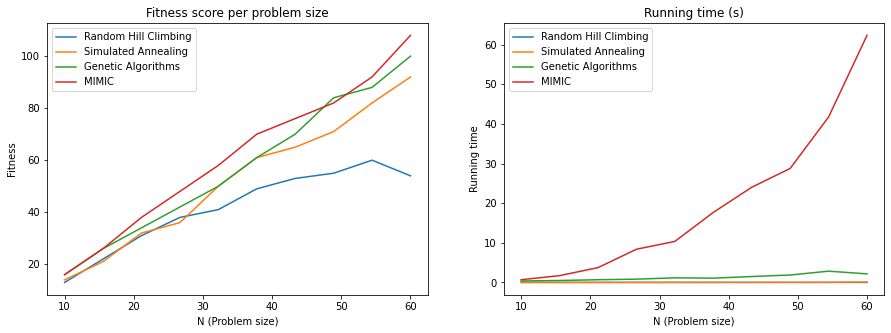

Wall time: 3min 33s


In [31]:
%%time

max_size = 60
size_list_k_flip_flop = np.linspace(10, max_size, 10)

list_history_k_flip_flop = []

for size in size_list_k_flip_flop:
    problem_fit_k_flip_flop = create_k_flip_flop_problem(size=int(size))
    history = run_random_opti_algo(problem_fit_k_flip_flop, max_attempts=MAX_ATTEMPTS, max_iters=MAX_ITERS, 
                                   init_temp=1.0, exp_const=0.005, min_temp=0.001, # SA parameters
                                   pop_size_ga=200, mutation_prob_ga=0.01, # GA parameters
                                   pop_size_mi=400, keep_pct_mi=0.4, # MIMIC parameters
                                   minimization=False)
    list_history_k_flip_flop.append(history)

plot_fitness_duration(size_list_k_flip_flop, list_history_k_flip_flop, problem_name="K Flip Flop")

Graphs saved at graphs/K Flip Flop_iteration_size.png


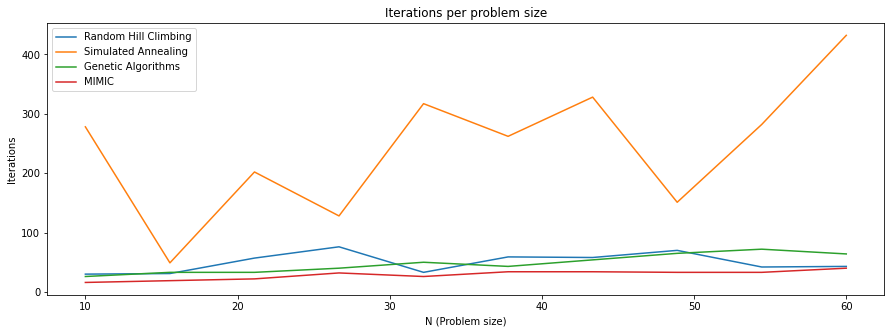

In [32]:
plot_iterations_size(size_list_k_flip_flop, list_history_k_flip_flop, problem_name="K Flip Flop")

Graphs saved at graphs/K Flip Flop_time_iteration_size.png


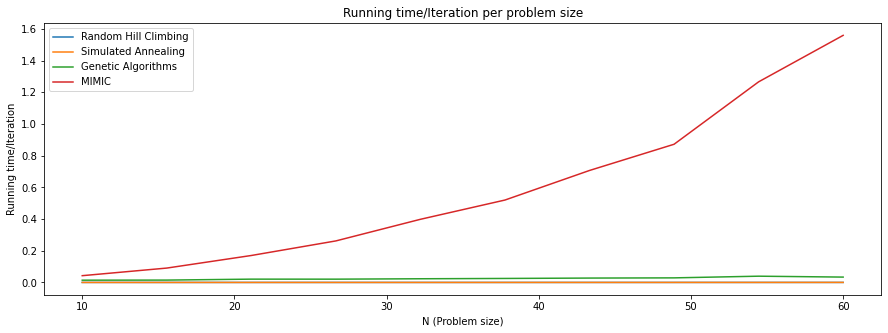

Average running time/iteration for RHC: 9.11304733912864e-05 seconds/iteration
Average running time/iteration for SA: 0.00011069828338606349 seconds/iteration
Average running time/iteration for GA: 0.02492081934113249 seconds/iteration
Average running time/iteration for MI: 0.5886229852986309 seconds/iteration


In [41]:
plot_time_iterations_size(size_list_k_flip_flop, list_history_k_flip_flop, problem_name="K Flip Flop")